In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import json
import sys
import glob
import pandas
import seaborn as sns
from collections import defaultdict
sys.path.append("..")
sys.path.append("../src")
from prepare_echo_dataset_pn import PN_PATTERNS_1024_8

[[0.9999998  0.99698048 0.98453246 0.92584061 0.9610394  0.49364882
  0.        ]
 [0.99999998 0.99825974 0.99374598 0.93517316 0.97469776 0.48974204
  0.        ]
 [1.         0.99950617 0.99839279 0.94632207 0.98632407 0.47267077
  0.        ]
 [1.         0.99993906 0.99947022 0.95022756 0.98920147 0.46531212
  0.        ]]


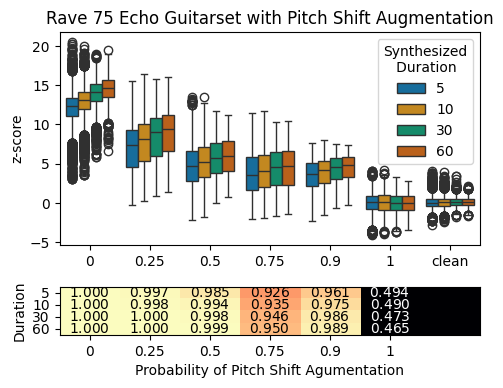

In [8]:
d = dict(perc=[], z=np.array([]))
durstr = "Synthesized\n   Duration"
d[durstr] = []
percs = [0, 0.25, 0.5, 0.75, 0.9, 1, "clean"]
durs = [5, 10, 30, 60]
all_results = defaultdict(lambda: [])
for dur in durs:
    for perc in percs:
        for seed in range(4):
            try:
                if perc == "clean":
                    results = json.load(open(f"results/other_clean_dur{dur}_seed{seed}.json"))
                elif perc == 0:
                    results = json.load(open(f"results/other_75_dur{dur}_seed{seed}.json"))
                else:
                    results = json.load(open(f"results/other_75_dur{dur}_pitch{perc}_seed{seed}.json"))
                hamm = 512
                values = []
                for k, r in results.items():
                    if "z_75" in r:
                        values.append(r["z_75"])
                t = np.concatenate(tuple(values))
                d["perc"] += [perc]*(t.size)
                d["z"] = np.concatenate((d["z"], t))
                all_results[(perc, dur)] = np.concatenate((all_results[(perc, dur)], t))
                d[durstr] += [dur]*(t.size)
            except:
                continue

fac = 0.5
plt.figure(figsize=(fac*10, fac*8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2, colspan=1)
sns.boxplot(data=pandas.DataFrame(data=d), x="perc", y="z", hue=durstr, hue_order=durs, palette="colorblind")
plt.ylabel("z-score")
plt.xlabel("")
plt.title("Rave 75 Echo Guitarset with Pitch Shift Augmentation")

plt.subplot(313)
from sklearn.metrics import roc_curve, roc_auc_score
A = np.zeros((len(durs), len(percs)))
for duridx, dur in enumerate(durs):
    f = all_results[("clean", dur)]
    for percidx, perc in enumerate(percs[0:-1]):
        t = all_results[(perc, dur)]
        y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
        y_score = np.concatenate((f, t))
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        auroc = roc_auc_score(y_true, y_score)
        A[duridx, percidx] = auroc
print(A)
vmin = 0.65
vmax = 1
plt.imshow(A, aspect=0.2, cmap='magma', interpolation='none', vmin=vmin, vmax=vmax)
plt.yticks(np.arange(len(durs)), durs)
#plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(np.arange(len(percs)-1), percs[0:-1])
plt.xlabel("Probability of Pitch Shift Agumentation")
for i in range(A.shape[0]):
    for j in range(A.shape[1]-1):
        color = 'white'
        if A[i, j] > vmin + 0.6*(vmax-vmin):
            color = 'black'
        plt.text(j, i, "${:.3f}$".format(A[i, j]), color=color, horizontalalignment='center', verticalalignment='center')
plt.ylabel("Duration")
plt.tight_layout()

plt.savefig("../Writeup/figs/RavePercPitchShift.svg", bbox_inches='tight')